In [1]:
import numpy as np 
import torch 
from torch.autograd import Variable
import sys 
from sfcn.sfcn_load import give_pretrained_sfcn
from data.oasis.load_oasis3 import give_oasis_data
import matplotlib.pyplot as plt 
from matplotlib.colors import Normalize

In [2]:
model=give_pretrained_sfcn("0", "age")
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Number of GPUs: ", torch.cuda.device_count())
model=model.to(device)

Load model for age - run: 0
Number of GPUs:  4


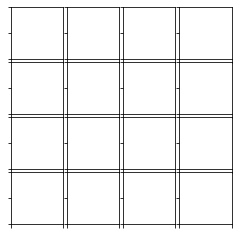

In [58]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

plt.figure(figsize = (4,4))
gs1 = gridspec.GridSpec(4, 4)
gs1.update(wspace=0.025, hspace=0.05) # set the spacing between axes. 

for i in range(16):
   # i = i + 1 # grid spec indexes from 0
    ax1 = plt.subplot(gs1[i])
    ax1.set_xticklabels([])
    ax1.set_yticklabels([])
    ax1.set_aspect('equal')

plt.show()

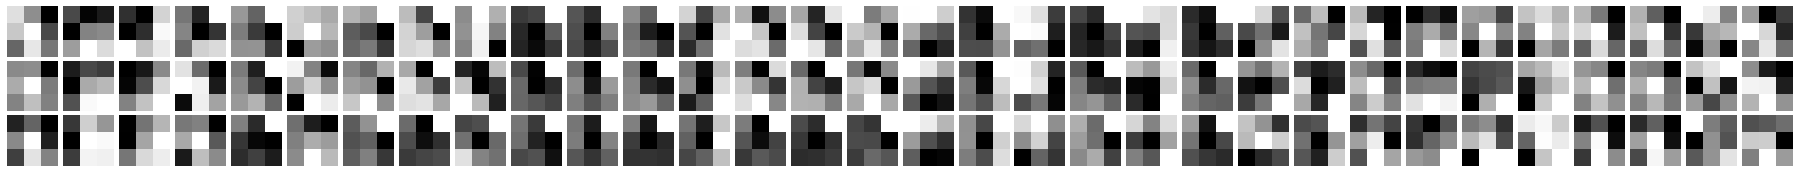

In [25]:
conv_layer_1=model.module.feature_extractor[0][0]
kernels=conv_layer_1.weight.data.squeeze().cpu().detach()
n_channels=kernels.shape[0]
fig,ax=plt.subplots(nrows=3,ncols=n_channels,figsize=(n_channels,3))
for i in range(n_channels):
    for j in range(3):
        ax[j][i].imshow(kernels[i][j],'gray')
        ax[j][i].axis('off')

plt.subplots_adjust(wspace=0.1, hspace=0)



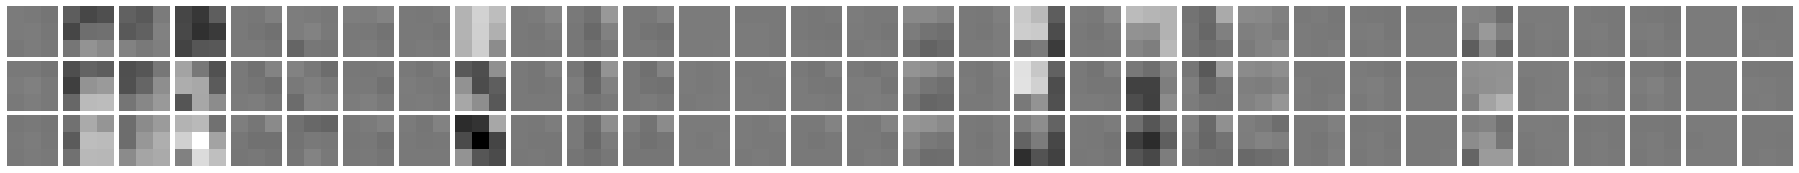

In [27]:
conv_layer_1=model.module.feature_extractor[0][0]
kernels=conv_layer_1.weight.data.squeeze().cpu().detach()
n_channels=kernels.shape[0]
fig,ax=plt.subplots(nrows=3,ncols=n_channels,figsize=(n_channels,3))
for i in range(n_channels):
    for j in range(3):
        ax[j][i].imshow(kernels[i][j],'gray',norm=nm_kernel)
        ax[j][i].axis('off')

plt.subplots_adjust(wspace=0.1, hspace=0)

In [54]:
def plot_3d_kernels(kernels):
    
    n_in_channels=kernels.shape[0]
    n_out_channels=kernels.shape[1]
    
    nm_kernel=Normalize(vmin=kernels.min(), vmax=kernels.max(), clip=False)
    
    fig,ax=plt.subplots(nrows=3*n_out_channels,ncols=n_in_channels,figsize=(n_in_channels,3*n_out_channels),squeeze=False)
    
    for out_ in range(n_out_channels):
        for in_ in range(n_in_channels):
            for j in range(3):
                ax[j+out_,in_].tick_params(axis='x',bottom = False, top = False)
                ax[j+out_,in_].tick_params(axis='y',left= False, right = False)
                ax[j+out_,in_].imshow(kernels[in_,out_,j],'gray')#,norm=nm_kernel)
                ax[j+out_,in_].set_xticklabels([])
                ax[j+out_,in_].set_yticklabels([])

    plt.subplots_adjust(wspace=0., hspace=0.3)


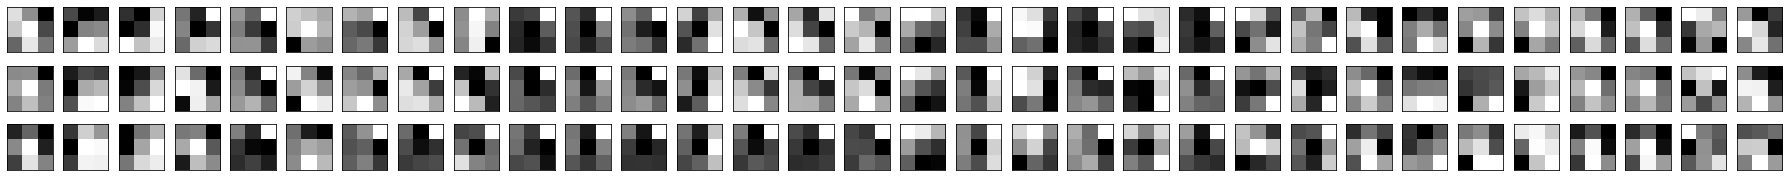

In [55]:
kernels=model.module.feature_extractor[0][0].weight.data.cpu().detach()
plot_3d_kernels(kernels)
